# Introduction

The idea presented in this notebook is to find the dissimilarity between a pair of satellite images of the same geograhical region. A pair of satellite image consist of an image taken during flood, and an image taken few days before the flood.

An example image pair is given below,


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

flooded_img = mpimg.imread('../input/louisiana-flood-2016/train/10003.png')
normal_img = mpimg.imread('../input/louisiana-flood-2016/train/10003_1.png')

plt.subplot(1,2,1)
plt.imshow(flooded_img)
plt.subplot(1,2,2)
plt.imshow(normal_img)
plt.tight_layout()
plt.show()

If the dissimilarity is high it means, that particular geographical region is flooded. Low value of dissimilarity means, that region is less affected by flood.

This approach to figure out flooded regions can be applied to all other natural disaster as well, since the main idea here is to measure the changes of a particular region before and during the disaster.

# Imoprt libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os
import time
from tqdm.autonotebook import tqdm

%matplotlib inline

# Preparing the data

In [ ]:
img_augmentation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])       
    ])

In [ ]:
class LouisianaDataset(Dataset):
    def __init__(self, type):
        if type == 'train':
            self.df = pd.read_csv("../input/louisiana-flood-2016/train.csv")
            self.image_folder = "../input/louisiana-flood-2016/train/"
        else:
            self.df = pd.read_csv("../input/louisiana-flood-2016/test.csv")
            self.image_folder = "../input/louisiana-flood-2016/test/"
        
        self.imgs = self.df[self.df['Normal']==1]
        self.imgs = self.imgs['Image ID'].values

    def __getitem__(self, idx):
        before_img_path = os.path.join(self.image_folder, self.imgs[idx])
        flood_img_path = glob(self.image_folder+self.imgs[idx].split('.')[0]+'_*')[0]

        before_img = Image.open(before_img_path)
        before_img = img_augmentation(before_img)
        flood_img = Image.open(flood_img_path)
        flood_img = img_augmentation(flood_img)

        label = int(flood_img_path.split('_')[-1].split('.')[0])
        
        return (before_img,flood_img,torch.as_tensor([label], dtype=torch.float))

    def __len__(self):
        return len(self.imgs)

# Load the dataset

In [ ]:
train_data = LouisianaDataset('train')
print('No. of training samples: ',len(train_data))
valid_data = LouisianaDataset('valid')
print('No. of validation samples: ',len(valid_data))

In [ ]:
num_workers = 0
bs = 8

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=True, num_workers=num_workers)

# Model

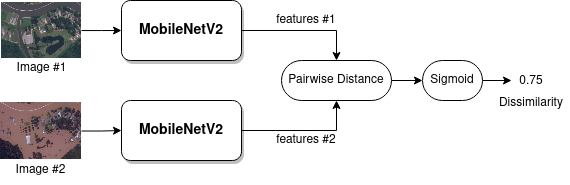

In [ ]:
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.network1 = models.mobilenet_v2(pretrained=True)
        self.network2 = models.mobilenet_v2(pretrained=True)
        self.distance = torch.nn.PairwiseDistance(keepdim=True)
        self._bn = torch.nn.BatchNorm1d(1)
        self._act = torch.nn.Sigmoid()
        
    def forward(self, input1, input2):
        feats1 = self.network1(input1)
        feats2 = self.network2(input2)
        distance = self.distance(feats1, feats2)
        output = self._bn(distance)
        output = self._act(output)
        return output
        

In [ ]:
%%capture
model = SiameseNetwork()
model.cuda()

In [ ]:
num_epochs = 25
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

# Training

In [ ]:
train_losses = []
valid_losses = []

In [ ]:
start_ts = time.time()
for epoch in range(num_epochs):
    # ----------------- TRAINING  -------------------- 
    train_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Train_loss: ", total=len(train_loader))
    # set model to training
    model.train()
    
    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        # training step for single batch
        model.zero_grad()
        optimizer.zero_grad()
        pred = model(img0,img1)
        loss = criterion(pred,label)
        loss.backward()
        optimizer.step()

        # getting training quality data
        train_loss += loss.item()

        # updating progress bar
        progress.set_description("Train_loss: {:.4f}".format(train_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    train_loss = train_loss/len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, training loss: {train_loss}")

    train_losses.append(train_loss)
    
    # ----------------- VALIDATION -------------------- 
    
    valid_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(valid_loader), desc="Valid_loss: ", total=len(valid_loader))
    # set model to training
    model.eval()
    
    for i, data in progress:
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        pred = model(img0,img1)
        loss = criterion(pred,label)

        # getting validation quality data
        valid_loss += loss.item()

        # updating progress bar
        progress.set_description("Valid_loss: {:.4f}".format(train_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    valid_loss = valid_loss/len(valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, valid loss: {valid_loss}")

    valid_losses.append(valid_loss)
    
    print('- '*50)

print(f"Training time: {time.time()-start_ts}s")

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")

plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.savefig('traing_progress.png')
plt.show()

# Inference

In [ ]:
print("Inference")

mean = np.array([0.456, 0.406, 0.485])
std = np.array([0.224, 0.225, 0.229])

model.eval()

columns = 2; rows = 10
fig=plt.figure(figsize=(columns*5, rows*5))
for i in range(0, columns*rows, 2):
    image0, image1, label = valid_data[i]
    img0, img1 = image0[None,:,:,:], image1[None,:,:,:]
    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    pred = model(img0,img1)
    
    fig.add_subplot(rows,columns,i+1)
    image0 = image0.permute(1, 2, 0).numpy()
    image0 = image0 * std
    image0 = image0 + mean
    plt.imshow(image0)
    plt.title("Before flood")
    plt.tight_layout()
    fig.add_subplot(rows,columns,i+2)
    image1 = image1.permute(1, 2, 0).numpy()
    image1 = image1 * std
    image1 = image1 + mean
    plt.imshow(image1)
    ftitle_true = 'Flooded' if int(label.cpu().detach().numpy())==1 else 'Not flooded'
    plt.title('Label: '+ftitle_true +', Dissimilarity: '+str(round(float(pred.cpu().detach().numpy()), 4)))
    plt.tight_layout()

plt.show()

# Summary of prediction results

In [ ]:
all_preds = torch.tensor([]).cuda()
all_targets = torch.tensor([]).cuda()

for i, data in enumerate(valid_loader):
    model.eval()
    
    img0, img1, label = data
    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    pred = model(img0,img1)
    all_preds = torch.cat((all_preds, pred), dim=0)
    all_targets = torch.cat((all_targets, label), dim=0)
    
all_preds = all_preds.squeeze().cpu().detach().numpy()
all_targets = all_targets.squeeze().cpu().detach().numpy()
torch.cuda.empty_cache()

In [ ]:
flood_preds = []
normal_preds = []
for i, label in enumerate(all_targets):
    if label == np.float32(1.0):
        flood_preds.append(float(all_preds[i]))
    else:
        normal_preds.append(float(all_preds[i]))

In [ ]:
fig = plt.figure(tight_layout=True)
fig.add_subplot(1, 2, 1)
plt.hist(flood_preds)
plt.title('Flood hist')
plt.xlabel("Dissimilarity")
plt.ylabel("No of examples")
fig.add_subplot(1, 2, 2)
plt.hist(normal_preds)
plt.title('Normal hist')
plt.xlabel("Dissimilarity")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(normal_preds) + np.std(normal_preds)
threshold

In [ ]:
all_preds[all_preds > threshold] = 1
all_preds[all_preds != 1] = 0

In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
confusion_matrix(all_preds, all_targets)

# References
- https://www.paperswithcode.com/paper/siamese-neural-networks-for-one-shot-image
- https://keras.io/examples/vision/siamese_network/
- https://sorenbouma.github.io/blog/oneshot/